In [1]:
from tensorflow.keras.layers import Dense, Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
batch_size = 64
width, height, channel = 400, 400, 3
no_epochs = 10
verbosity = 2
input_shape = (width, height, channel)

In [3]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=1000
)

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('preprocessed_data/train',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


pretrained_model.trainable=False

model=Sequential()

# model.add(pretrained_model)

model = tf.keras.Sequential()

for layer in pretrained_model.layers[:-1]: # just exclude last layer from copying
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

# model.add(MaxPooling2D())
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(2, activation='softmax'))

model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[metrics.AUC(), 'accuracy'])

Found 2603 images belonging to 2 classes.


In [5]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//batch_size,
                    epochs = no_epochs,
                    verbose=verbosity,
                   )

Epoch 1/10
40/40 - 22s - loss: 0.9160 - auc: 0.5565 - accuracy: 0.5356
Epoch 2/10
40/40 - 21s - loss: 0.5765 - auc: 0.8110 - accuracy: 0.7353
Epoch 3/10
40/40 - 21s - loss: 0.5097 - auc: 0.8493 - accuracy: 0.7653
Epoch 4/10
40/40 - 21s - loss: 0.4481 - auc: 0.8913 - accuracy: 0.8098
Epoch 5/10
40/40 - 21s - loss: 0.4071 - auc: 0.9062 - accuracy: 0.8259
Epoch 6/10
40/40 - 21s - loss: 0.4116 - auc: 0.8941 - accuracy: 0.8109
Epoch 7/10
40/40 - 21s - loss: 0.3542 - auc: 0.9278 - accuracy: 0.8436
Epoch 8/10
40/40 - 21s - loss: 0.3654 - auc: 0.9167 - accuracy: 0.8326
Epoch 9/10
40/40 - 21s - loss: 0.3249 - auc: 0.9386 - accuracy: 0.8582
Epoch 10/10
40/40 - 21s - loss: 0.3059 - auc: 0.9468 - accuracy: 0.8637


In [6]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory('preprocessed_data/test',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

model.evaluate(valid_generator)

Found 650 images belonging to 2 classes.
11/11 [==============================] - 5s 487ms/step - loss: 0.2843 - auc: 0.9559 - accuracy: 0.8862


[0.2843196988105774, 0.9558520317077637, 0.8861538171768188]

In [7]:
# https://dryjelly.tistory.com/147

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

In [9]:
get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output(valid_generator[0][0])
class_weights = model.layers[-1].get_weights()[0]

In [11]:
import numpy as np

output = []
for num, idx in enumerate(np.argmax(predictions,axis=1)):
    cam = tf.matmul(np.expand_dims(class_weights[:,idx],axis = 0),
                    np.transpose(np.reshape(conv_outputs[num],(25*25,1024))))
    cam = tf.keras.backend.eval(cam)
    output.append(cam)

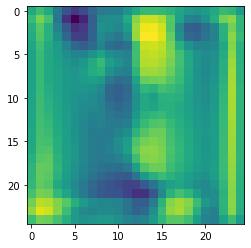

In [12]:
plt.imshow(np.reshape(output[0][0], (25, 25)))

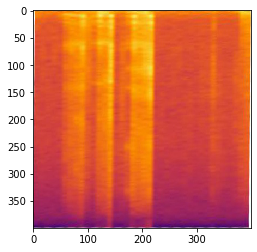

In [13]:
plt.imshow(valid_generator[0][0][0])

In [20]:
test_image = tf.keras.preprocessing.image.load_img(
    "test-images/negative.PNG", grayscale=False, color_mode="rgb", target_size=(400, 400), interpolation="nearest"
)

input_arr = tf.keras.preprocessing.image.img_to_array(test_image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

model.predict(input_arr)

array([[0., 1.]], dtype=float32)

In [21]:
test_image = tf.keras.preprocessing.image.load_img(
    "test-images/positive-non.PNG", grayscale=False, color_mode="rgb", target_size=(400, 400), interpolation="nearest"
)

input_arr = tf.keras.preprocessing.image.img_to_array(test_image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

model.predict(input_arr)

array([[0., 1.]], dtype=float32)

In [22]:
test_image = tf.keras.preprocessing.image.load_img(
    "test-images/positive-y.PNG", grayscale=False, color_mode="rgb", target_size=(400, 400), interpolation="nearest"
)

input_arr = tf.keras.preprocessing.image.img_to_array(test_image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

model.predict(input_arr)

array([[0., 1.]], dtype=float32)